In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [351]:
class Averager:
    def fit(self, a):
        self.A = a
    
    def predict(self, B):
        
        predictions = []
        
        for i in B['valanda']:
            filtered_data = self.A[
                (self.A['savaites_diena'] == B.iloc[0]['savaites_diena']) & 
                (self.A['menuo'] == B.iloc[0]['menuo']) & 
                (self.A['valanda'] == i)
            ]
            
            mean_value = filtered_data['value'].mean()
            predictions.append(mean_value)
        
        return predictions

In [ ]:
#destytojo klase.
# # ['MM','DD', 'HH', 'value']]

# class Analyzer():
#   def __init__(self):
#     self.DF_DATA = None

#   def fit(self, data, X_features:list, y_target:str):
#     self.DF_DATA = data[X_features+[y_target]].groupby(X_features).mean().reset_index()
#     pass
 
#   def predict(self, d:str):
#    dt = pd.to_datetime(d)
#    M = dt.month
#    D = dt.day_of_week
#    h24 = self.DF_DATA.query(expr='MM == @M and DD == @D')
#    return h24[['HH', 'value']]

In [352]:
df_dideli = pd.read_json(r"C:\Users\pauli\Downloads\stambiuju_vartotoju_suvartojimas_mwh.json")
df_mazi = pd.read_json(r"C:\Users\pauli\Downloads\skirstomojo_tinklo_suvartojimas_mwh.json")

In [353]:
df_orai1 = pd.read_json(r"C:\Users\pauli\Downloads\weather_data.json")
df_orai2 = pd.read_json(r"C:\Users\pauli\Downloads\weather_data(1).json")
df_orai3 = pd.read_json(r"C:\Users\pauli\Downloads\weather_data(2).json")

In [354]:
df_orai = pd.concat([df_orai1, df_orai2, df_orai3])

In [355]:
df_dideli.head(3)

,id,value,ltu,utc
0,1102,91.465,2023-01-01 02:00:00,2023-01-01 00:00:00
1,1102,91.878,2023-01-01 03:00:00,2023-01-01 01:00:00
2,1102,91.540,2023-01-01 04:00:00,2023-01-01 02:00:00


In [356]:
df_mazi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18478 entries, 0 to 18477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      18478 non-null  int64  
 1   value   18478 non-null  float64
 2   ltu     18478 non-null  object 
 3   utc     18478 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 577.6+ KB


In [357]:
df_mazi.head(3)

,id,value,ltu,utc
0,1101,683.070,2023-01-01 02:00:00,2023-01-01 00:00:00
1,1101,656.493,2023-01-01 03:00:00,2023-01-01 01:00:00
2,1101,639.742,2023-01-01 04:00:00,2023-01-01 02:00:00


In [358]:
df = df_dideli.merge(df_mazi[['value', 'ltu']], on='ltu', how='left')
# df=df_mazi

In [359]:
df['value'] = df['value_x'] + df['value_y']
df=df.drop(columns = ['id', 'utc', 'value_x', 'value_y'])
# df=df.drop(columns = ['id', 'utc'])

In [360]:
df = df.merge(df_orai[['obs_time_utc', 'air_temperature', 'wind_speed', 'cloud_cover']], left_on='ltu', right_on='obs_time_utc', how='left')

In [361]:
df['air_temperature'] = df['air_temperature'].ffill()
df['wind_speed'] = df['wind_speed'].ffill()
df['cloud_cover'] = df['cloud_cover'].fillna(100.0)

In [362]:
df=df.drop(columns = ['obs_time_utc'])

In [363]:
df['ltu'] = pd.to_datetime(df['ltu'])
df['metai'] = df['ltu'].dt.year
df['menuo'] = df['ltu'].dt.month
df['diena'] = df['ltu'].dt.day
df['valanda'] = df['ltu'].dt.hour
df['savaites_diena'] = df['ltu'].dt.dayofweek

In [364]:
df_08 = df[(df['diena'] == 8) & (df['metai'] == 2025) & (df['menuo'] == 2)]
df = df.query("not (diena == 8 and metai == 2025 and menuo == 2)")

In [365]:
vidurkis = Averager()
vidurkis.fit(df)
prognoze = vidurkis.predict(df_08)

In [366]:
df_rezultatai = df_08[['valanda', 'value']].copy()
df_rezultatai['prognoze_vidurkis'] = prognoze

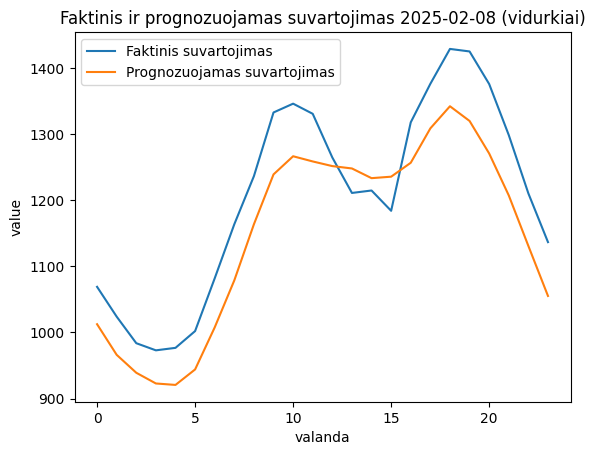

In [367]:
sns.lineplot(data=df_rezultatai, x='valanda', y='value', label='Faktinis suvartojimas')
sns.lineplot(data=df_rezultatai, x='valanda', y='prognoze_vidurkis', label='Prognozuojamas suvartojimas')
plt.title('Faktinis ir prognozuojamas suvartojimas 2025-02-08 (vidurkiai)')
plt.show()

In [368]:
Y_target = df['value']
X_features = df.drop(columns=['value', 'ltu'])

X_train, X_test, y_train, y_test = train_test_split(X_features, Y_target, test_size=0.15, random_state=0)

In [369]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train[['air_temperature','wind_speed','cloud_cover']])
X_train_scaled = scaler.transform(X_train[['air_temperature','wind_speed','cloud_cover']]); X_train_scaled

array([[ 0.39733132, -1.19548517, -1.60797267],
       [ 1.38374186, -0.59452072, -0.69391861],
       [ 0.15620874, -0.19387776, -1.60797267],
       ...,
       [-0.97268333, -0.12710393,  0.50878411],
       [-0.88500239, -0.66129455, -1.60797267],
       [ 0.21100933, -0.26065159, -0.40526996]])

In [370]:
air_temperature_sc, wind_speed_sc, cloud_cover_sc = zip(*X_train_scaled)
X_train['air_temperature'] = air_temperature_sc
X_train['wind_speed'] = wind_speed_sc
X_train['cloud_cover'] = cloud_cover_sc

In [371]:
X_test_scaled = scaler.transform(X_test[['air_temperature','wind_speed','cloud_cover']]); X_test_scaled

array([[ 1.66870491, -0.66129455, -1.60797267],
       [ 0.15620874, -1.12871134, -1.60797267],
       [-0.11779419, -0.12710393,  0.50878411],
       ...,
       [-0.00819302, -1.46258048, -1.60797267],
       [ 1.73446561,  0.00644372,  0.50878411],
       [-0.50139829,  0.34031286,  0.50878411]])

In [372]:
air_temperature_sc, wind_speed_sc, cloud_cover_sc = zip(*X_test_scaled)
X_test['air_temperature'] = air_temperature_sc
X_test['wind_speed'] = wind_speed_sc
X_test['cloud_cover'] = cloud_cover_sc ; X_test

,air_temperature,wind_speed,cloud_cover,metai,menuo,diena,valanda,savaites_diena
14224,1.668705,-0.661295,-1.607973,2024,8,15,17,3
12624,0.156209,-1.128711,-1.607973,2024,6,10,1,0
7479,-0.117794,-0.127104,0.508784,2023,11,8,15,2
4825,0.474052,-0.394199,-1.607973,2023,7,21,4,4
565,-1.268606,-0.260652,0.797433,2023,1,24,15,1
...,...,...,...,...,...,...,...,...
12610,0.923417,1.208373,0.797433,2024,6,9,11,6
15665,-0.095874,-0.127104,0.797433,2024,10,14,18,0
5997,-0.008193,-1.462580,-1.607973,2023,9,8,0,4
5475,1.734466,0.006444,0.508784,2023,8,17,6,3


In [373]:
regressor = DecisionTreeRegressor(random_state=42)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

score = r2_score(y_test, y_pred)

print(f"R² score: {score:.2f}")
# y_pred = regressor.predict(df_test)

R² score: 0.85


In [374]:
duomenys08= df_08.drop(columns=['value', 'ltu'])
y_pred = regressor.predict(duomenys08)

In [375]:
df_rezultatai['prognoze_DTR'] = y_pred

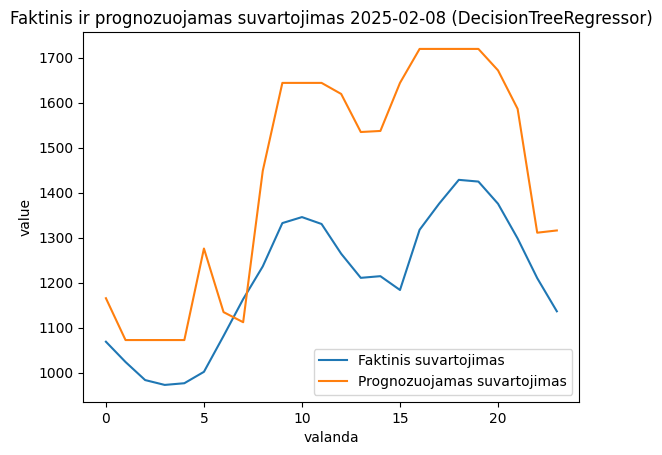

In [376]:
sns.lineplot(data=df_rezultatai, x='valanda', y='value', label='Faktinis suvartojimas')
sns.lineplot(data=df_rezultatai, x='valanda', y='prognoze_DTR', label='Prognozuojamas suvartojimas')
plt.title('Faktinis ir prognozuojamas suvartojimas 2025-02-08 (DecisionTreeRegressor)')
plt.show()

In [377]:
regressor = RandomForestRegressor(random_state=42)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

score = r2_score(y_test, y_pred)

print(f"R² score: {score:.2f}")


R² score: 0.92


In [378]:
duomenys08= df_08.drop(columns=['value', 'ltu'])
y_pred = regressor.predict(duomenys08)

In [379]:
df_rezultatai['prognoze_RFR'] = y_pred

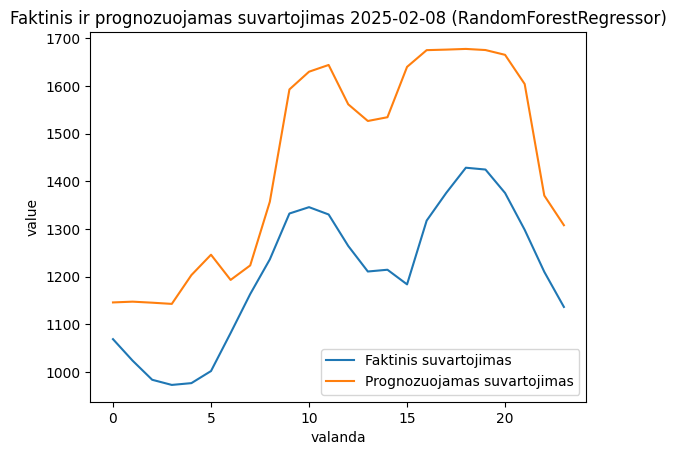

In [380]:
sns.lineplot(data=df_rezultatai, x='valanda', y='value', label='Faktinis suvartojimas')
sns.lineplot(data=df_rezultatai, x='valanda', y='prognoze_RFR', label='Prognozuojamas suvartojimas')
plt.title('Faktinis ir prognozuojamas suvartojimas 2025-02-08 (RandomForestRegressor)')
plt.show()

In [381]:
df_rezultatai

,valanda,value,prognoze_vidurkis,prognoze_DTR,prognoze_RFR
18458,0,1068.992,1012.485444,1165.606,1146.02882
18459,1,1023.915,966.193222,1072.678,1147.65425
18460,2,983.777,939.082667,1072.678,1145.47989
18461,3,972.988,922.893333,1072.678,1142.96051
18462,4,976.748,920.709111,1072.678,1203.39583
18463,5,1002.086,944.103222,1275.993,1246.11382
18464,6,1081.828,1007.669333,1134.753,1193.26555
18465,7,1163.594,1078.758778,1112.348,1223.66867
18466,8,1236.304,1163.574000,1448.567,1357.19439
18467,9,1332.549,1238.922111,1644.014,1592.84696


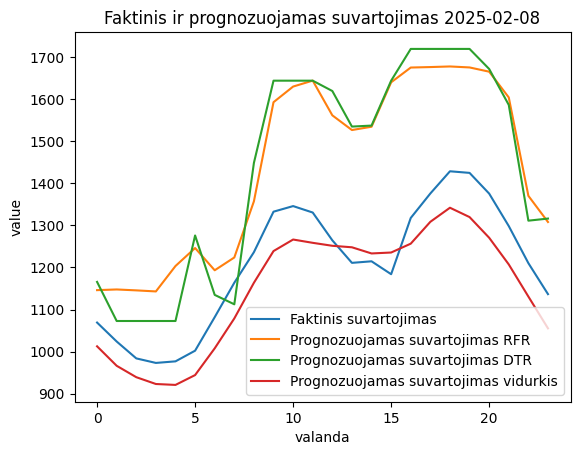

In [382]:
sns.lineplot(data=df_rezultatai, x='valanda', y='value', label='Faktinis suvartojimas')
sns.lineplot(data=df_rezultatai, x='valanda', y='prognoze_RFR', label='Prognozuojamas suvartojimas RFR')
sns.lineplot(data=df_rezultatai, x='valanda', y='prognoze_DTR', label='Prognozuojamas suvartojimas DTR')
sns.lineplot(data=df_rezultatai, x='valanda', y='prognoze_vidurkis', label='Prognozuojamas suvartojimas vidurkis')
plt.title('Faktinis ir prognozuojamas suvartojimas 2025-02-08')
plt.show()